In [126]:
import os
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.merge import merge
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import subprocess

In [115]:
cwd = os.getcwd()
print(cwd)

/Users/jamesbyers/code/github/Kaggle/openai_to_z


In [116]:
site_csv_path = os.path.join(cwd, 'papers/2018deSouza', '2018deSouza_sites.csv')
tile_csv_path = os.path.join(cwd, 'lidar_filtered', 'cms_brazil_lidar_tile_inventory.csv')

In [151]:
# Load archaeological site data
sites_df = pd.read_csv(site_csv_path).iloc[:, 2:]
sites_df['longitude'], sites_df['latitude'] = sites_df['latitude'], sites_df['longitude']
sites_gdf = gpd.GeoDataFrame(
    sites_df,
    geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
    crs="EPSG:4326"
)

print(sites_gdf.head())
print(len(sites_gdf))

   site structure                 type  latitude  longitude  area_ha  \
0  Mt01         l   circular_enclosure   -9.4071   -57.9452     1.61   
1  Mt02         l  hexagonal_enclosure   -9.8711   -57.8872     3.18   
2  Mt03         l   circular_enclosure   -9.7048   -57.8772     5.11   
3  Mt04         l            enclosure   -9.8132   -57.8212     2.41   
4  Mt05         l   circular_enclosure   -9.8221   -57.7557     1.77   

   potential_population                  geometry  
0                 239.0  POINT (-57.9452 -9.4071)  
1                 454.0  POINT (-57.8872 -9.8711)  
2                 719.0  POINT (-57.8772 -9.7048)  
3                 349.0  POINT (-57.8212 -9.8132)  
4                 262.0  POINT (-57.7557 -9.8221)  
104


In [139]:
# --- Load LiDAR tile metadata ---
tiles_df = pd.read_csv(tile_csv_path)

print(tiles_df.head())

                  filename   max_lat   min_lat    max_lon    min_lon  \
0   ANA_A01_2017_laz_0.laz -3.363488 -3.372548 -54.992912 -55.001927   
1   ANA_A01_2017_laz_1.laz -3.347679 -3.354482 -55.001946 -55.010093   
2  ANA_A01_2017_laz_10.laz -3.381571 -3.381970 -54.992893 -55.001891   
3  ANA_A01_2017_laz_11.laz -3.363507 -3.372565 -55.001909 -55.010098   
4  ANA_A01_2017_laz_12.laz -3.372516 -3.381571 -54.986568 -54.992912   

    file_type  file_size_mb file_format  version   created utmzone  \
0  pointcloud     85.374953     LAS/LAZ      1.2  214/2017     21S   
1  pointcloud     50.359133     LAS/LAZ      1.2  158/2017     21S   
2  pointcloud      2.870918     LAS/LAZ      1.2  158/2017     21S   
3  pointcloud     81.088782     LAS/LAZ      1.2  214/2017     21S   
4  pointcloud     50.974691     LAS/LAZ      1.2  214/2017     21S   

                                                 srs  
0  +proj=utm +zone=21 +south +ellps=GRS80 +towgs8...  
1  +proj=utm +zone=21 +south +ellps=

In [140]:
tiles_gdf = gpd.GeoDataFrame(
    tiles_df,
    geometry=[
        box(row['min_lon'], row['min_lat'], row['max_lon'], row['max_lat'])
        for _, row in tiles_df.iterrows()
    ],
    crs="EPSG:4326"
)

In [149]:
# Spatial join to check which points fall in any tile polygon
joined = gpd.sjoin(sites_gdf, tiles_gdf, how="left", predicate="within")
inside_tiles = joined[~joined['index_right'].isna()]
print(f"{len(inside_tiles)} out of {len(sites_gdf)} sites are within LiDAR tile bounds.")


0 out of 104 sites are within LiDAR tile bounds.


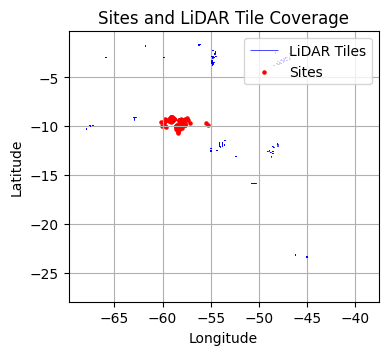

In [150]:
# Plot tile boxes and site points
fig, ax = plt.subplots(figsize=(4, 4))
tiles_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=0.5, label="LiDAR Tiles")
sites_gdf.plot(ax=ax, color='red', markersize=5, label="Sites")
plt.legend()
plt.title("Sites and LiDAR Tile Coverage")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [152]:
joined = gpd.sjoin(sites_gdf, tiles_gdf, how="left", predicate="within")
inside_tiles = joined[~joined['index_right'].isna()]
print(f"{len(inside_tiles)} out of {len(sites_gdf)} sites fall within any LiDAR tile.")

0 out of 104 sites fall within any LiDAR tile.


In [155]:
from scipy.spatial import cKDTree
import numpy as np

# Create centroids for each tile
tiles_gdf['centroid'] = tiles_gdf.geometry.centroid
tiles_centroids = tiles_gdf.set_geometry('centroid')


# Extract coordinates
site_coords = np.array(list(sites_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
tile_coords = np.array(list(tiles_centroids.geometry.apply(lambda geom: (geom.x, geom.y))))

# Build KDTree and query nearest neighbour
tile_tree = cKDTree(tile_coords)
distances, indices = tile_tree.query(site_coords, k=1)

# Attach results back to site GeoDataFrame
sites_gdf['nearest_tile_index'] = indices
sites_gdf['distance_to_tile_deg'] = distances

/var/folders/55/3_yjz_1s37vcxh8ld7nlc8k00000gn/T/ipykernel_59828/4207988477.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tiles_gdf['centroid'] = tiles_gdf.geometry.centroid


In [158]:
sites_gdf['distance_to_tile_deg'].min()

np.float64(0.12264579080277659)